In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in all the words.
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
# Build a vocab of characters and mappings to/from integers.
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Build the dataset.

# We can update the block_size to get more context.
block_size = 3            # Context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]    # Crop and append.
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [8]:
# We will embed the 27 chars in a 2-dimensional space.
C = torch.randn((27, 2))

In [9]:
C

tensor([[-0.5317, -0.8100],
        [ 0.0686, -0.4340],
        [ 0.6754, -0.1459],
        [ 0.4900, -2.1244],
        [ 0.3606,  0.8209],
        [-1.4012, -0.4754],
        [ 0.1316,  0.4431],
        [-0.2416, -0.1228],
        [ 0.7791,  1.1401],
        [-0.1821,  0.0800],
        [ 1.2458,  0.1638],
        [-0.1977,  0.1500],
        [ 0.6284,  0.9660],
        [ 0.3503, -1.3784],
        [-0.4973,  0.2641],
        [ 0.1854, -0.9773],
        [ 0.0410,  0.7770],
        [ 0.2522, -0.6684],
        [ 0.7541, -0.3799],
        [-1.3384,  1.1626],
        [ 0.9145,  0.3126],
        [ 0.4282,  1.1034],
        [-0.2724,  0.1731],
        [ 0.5598,  0.2846],
        [-0.1600, -0.8552],
        [ 0.4487,  0.2387],
        [-0.4292, -2.3721]])

In [10]:
# Let's take the emb for the ix=5.
# One way to get it is just pluck the row.
C[5]

tensor([-1.4012, -0.4754])

In [11]:
# Another way to do it is by having a one-hot encoding then multiply it with the emb matrix
# (think of it like a weight matrix).
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

# We will get the same thing as above because of matrix multiplication works.
# But for this lecture we will just use the way it is done in the cell above.

tensor([-1.4012, -0.4754])

In [12]:
# In pytorch we can index lists. Infact it can be tensors.
C[torch.tensor([5, 6, 7])]

tensor([[-1.4012, -0.4754],
        [ 0.1316,  0.4431],
        [-0.2416, -0.1228]])

In [13]:
# It also works with 2D tensors. So we can directly plug in tensor X and get the embeddings for the chars.
C[X].shape

torch.Size([32, 3, 2])

In [15]:
X[13, 2]

tensor(1)

In [16]:
C[X][13, 2]

tensor([ 0.0686, -0.4340])

In [17]:
# As can be seen, it plucks out the emb for 1.
C[1]

tensor([ 0.0686, -0.4340])

In [18]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [19]:
# Initialize the weights and biases of the neurons (MLP).
# We are working with the figure 1 on page 6 of this paper:
# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
# "A Neural Probabilistic Language Model"
# This is also available in the "relevant_papers" folder on the repo.

# 6 input dim because 3*2=6 -- from the shape above. These are the input values to the neurons.
# 100 are the output dims -- hyperparameter.
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [21]:
# This function gives us a list of all the tensors along a dim.
len(torch.unbind(emb, 1))     # --> We have a context_len of 3. This changes with block_size.

3

In [23]:
torch.cat(torch.unbind(emb, 1), dim=1).shape

torch.Size([32, 6])

In [25]:
# There is however a significantly better way to do this...
# Let's see it with a toy example -- learning `view` in pytorch.
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [26]:
a.shape

torch.Size([18])

In [36]:
# It can just help to reshape the tensor as we want.
b = a.view(3, 3, 2)

In [37]:
b.shape

torch.Size([3, 3, 2])

In [38]:
# Now applying the view on the emb.
emb.view(32, 6)

tensor([[-0.5317, -0.8100, -0.5317, -0.8100, -0.5317, -0.8100],
        [-0.5317, -0.8100, -0.5317, -0.8100, -1.4012, -0.4754],
        [-0.5317, -0.8100, -1.4012, -0.4754,  0.3503, -1.3784],
        [-1.4012, -0.4754,  0.3503, -1.3784,  0.3503, -1.3784],
        [ 0.3503, -1.3784,  0.3503, -1.3784,  0.0686, -0.4340],
        [-0.5317, -0.8100, -0.5317, -0.8100, -0.5317, -0.8100],
        [-0.5317, -0.8100, -0.5317, -0.8100,  0.1854, -0.9773],
        [-0.5317, -0.8100,  0.1854, -0.9773,  0.6284,  0.9660],
        [ 0.1854, -0.9773,  0.6284,  0.9660, -0.1821,  0.0800],
        [ 0.6284,  0.9660, -0.1821,  0.0800, -0.2724,  0.1731],
        [-0.1821,  0.0800, -0.2724,  0.1731, -0.1821,  0.0800],
        [-0.2724,  0.1731, -0.1821,  0.0800,  0.0686, -0.4340],
        [-0.5317, -0.8100, -0.5317, -0.8100, -0.5317, -0.8100],
        [-0.5317, -0.8100, -0.5317, -0.8100,  0.0686, -0.4340],
        [-0.5317, -0.8100,  0.0686, -0.4340, -0.2724,  0.1731],
        [ 0.0686, -0.4340, -0.2724,  0.1

In [46]:
# We can do the computation for the hidden layer.
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)     # -1 makes pytorch infer that dimension given the other dimension.

In [48]:
# Numbers are all between -1 and +1 due to the tanh.
h

tensor([[ 0.9999, -0.9938,  0.8547,  ..., -0.8765, -0.9007, -0.6529],
        [ 0.9996, -0.9852,  0.8054,  ...,  0.3414, -0.4571, -0.9464],
        [ 1.0000, -0.9967,  0.9458,  ..., -0.9964, -0.9989,  0.3555],
        ...,
        [-0.9621,  0.8756, -0.9909,  ..., -0.2411,  0.9890,  0.9849],
        [ 0.3789,  0.9185,  0.2037,  ...,  0.9921,  0.9885,  0.9092],
        [ 0.9514, -0.3889,  0.9030,  ...,  0.8777, -0.7336,  0.9897]])

In [47]:
h.shape

torch.Size([32, 100])

In [49]:
# Create the softmax layer. There are 27 output chars.
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [50]:
logits = h @ W2 + b2

In [51]:
logits.shape

torch.Size([32, 27])

In [58]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)

In [59]:
prob.shape

torch.Size([32, 27])

In [60]:
# Each row will sum 1.
prob[0].sum()

tensor(1.0000)

In [61]:
# Pluck out the probs assigned by the model to the correct label given by Y.
prob[torch.arange(32), Y]

tensor([6.6672e-13, 2.5447e-07, 3.0782e-01, 1.6771e-12, 1.5385e-09, 8.3130e-07,
        1.3691e-02, 1.3655e-11, 3.8660e-09, 2.6718e-08, 2.3409e-09, 9.7448e-12,
        2.5197e-15, 2.7106e-08, 2.3674e-11, 8.1370e-12, 1.7140e-08, 3.7008e-13,
        6.3204e-04, 1.4228e-09, 6.3568e-07, 1.0343e-03, 2.7549e-11, 1.0137e-03,
        3.6177e-13, 7.5531e-11, 2.6803e-07, 1.9524e-11, 5.9927e-11, 1.7716e-08,
        6.3148e-04, 1.5564e-12])

In [62]:
# The NLL
loss = -prob[torch.arange(32), Y].log().mean()

In [63]:
loss

tensor(19.1398)

## Cleaning up and re-writing. Also changing the hyper-parameters.

In [70]:
# Reading the entire dataset.
block_size = 3            # Context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]    # Crop and append.
X = torch.tensor(X)
Y = torch.tensor(Y)

X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [81]:
# Restructuring the above code to be able to read data and create training, dev and test splits.
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [82]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [99]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [100]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [101]:
for p in parameters:
    p.requires_grad = True

In [102]:
lossi = []
stepi = []

In [105]:
for i in range(50000):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # In the video we empirically determine that 0.1 is a good LR to use (around 50 mins in the video).
    lr = 0.1 if i < 100000 else 0.01
    # lr = 0.01 -- Did this when we were running the loop manually multiple times.
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.item())
        
print(loss.item())

2.1285746097564697


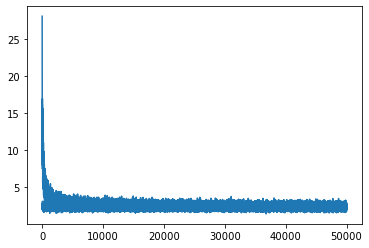

In [106]:
plt.plot(stepi, lossi)

In [107]:
# The loss above would be for a mini-batch. But this one is for the entire dataset.
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2138, grad_fn=<NllLossBackward0>)

In [108]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mora.
kayah.
see.
mel.
ryalayethan.
endrlee.
aderedieliigh.
poren.
eden.
van.
aar.
katelvontelin.
shdonrgihimies.
kindreelynn.
nocarmon.
zen.
dariyah.
faeha.
kay.
mus.
